In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/MyDrive/Project

/content/drive/MyDrive/Project


In [8]:
%%capture
!pip install transformers datasets evaluate accelerate

In [20]:
import torch
import evaluate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from datasets import Dataset
from transformers import (AutoModelForSequenceClassification,
                          AutoModel,
                          AutoTokenizer,
                          DataCollatorWithPadding,
                          TrainingArguments,
                          Trainer)

from utils import compute_metrics

import logging
logging.disable(logging.WARNING)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [14]:
def load_dataset(path):
    df = pd.read_csv(path, dtype={'Drug': str, 'Y': int})
    df.rename(columns={'Drug': 'text', 'Y': 'label'}, inplace=True)
    return Dataset.from_pandas(df)

train_dataset = load_dataset('data/BBB_train.csv')
test_dataset = load_dataset('data/BBB_test.csv')
valid_dataset = load_dataset('data/BBB_valid.csv')

In [12]:
checkpoint = 'DeepChem/ChemBERTa-10M-MLM'
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)

train_dataset.save_to_disk('data/train_dataset')
test_dataset.save_to_disk('data/test_dataset')
valid_dataset.save_to_disk('data/valid_dataset')

Map:   0%|          | 0/1421 [00:00<?, ? examples/s]

Map:   0%|          | 0/406 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1421 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/406 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/203 [00:00<?, ? examples/s]

In [19]:
metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metrics.compute(predictions=predictions, references=labels)


In [19]:
training_args = TrainingArguments(output_dir="results",
                                  gradient_accumulation_steps=1,
                                  learning_rate=1e-5,
                                  weight_decay=0.01,
                                  adam_epsilon=1e-8,
                                  max_grad_norm=1.0,
                                  num_train_epochs=10,
                                  warmup_ratio=0.1,
                                  logging_dir="logs",
                                  logging_first_step=True,
                                  logging_strategy="epoch",
                                  eval_strategy="epoch",
                                  dataloader_num_workers=2,
                                  seed=42)

In [20]:
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=valid_dataset,
                  tokenizer=tokenizer,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics)

In [21]:
trainer.train()
trainer.save_model(f'models/{checkpoint}_BBB')

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.197900,0.321874,0.906404,0.937705,0.934641,0.940789
2,0.194600,0.337421,0.906404,0.938111,0.929032,0.947368
3,0.183800,0.346678,0.896552,0.932039,0.917197,0.947368
4,0.179500,0.375069,0.891626,0.927152,0.933333,0.921053
5,0.172300,0.375623,0.891626,0.927632,0.927632,0.927632
6,0.167300,0.382481,0.886700,0.924590,0.921569,0.927632
7,0.148400,0.388473,0.891626,0.928105,0.922078,0.934211
8,0.157800,0.392949,0.891626,0.928105,0.922078,0.934211
9,0.166400,0.396875,0.891626,0.928105,0.922078,0.934211
10,0.169100,0.398249,0.886700,0.925081,0.916129,0.934211


In [22]:
results = trainer.evaluate(test_dataset)

In [23]:
print(results)

{'eval_loss': 0.5852072834968567, 'eval_accuracy': 0.8399014778325123, 'eval_f1': 0.8932676518883416, 'eval_precision': 0.8888888888888888, 'eval_recall': 0.8976897689768977, 'eval_runtime': 0.5851, 'eval_samples_per_second': 693.909, 'eval_steps_per_second': 87.166, 'epoch': 10.0}


In [31]:
drugbank_smiles = pd.read_csv('data/drugbank_smiles.csv', dtype={'smiles': str})
drugbank_smiles.rename(columns={'smiles': 'text'}, inplace=True)
drugbank_smiles = drugbank_smiles[['text']]

drugbank_dataset = Dataset.from_pandas(drugbank_smiles)
drugbank_dataset = drugbank_dataset.map(tokenize_function, batched=True)

predictions = trainer.predict(drugbank_dataset)

Map:   0%|          | 0/8288 [00:00<?, ? examples/s]

In [35]:
drugbank_smiles['predictions'] = np.argmax(predictions.predictions, axis=-1)
drugbank_smiles['logits_0'] = predictions.predictions[:,0]
drugbank_smiles['logits_1'] = predictions.predictions[:,1]

In [39]:
drugbank_smiles.head()

,text,predictions,logits_0,logits_1
0,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,0,2.621075,-2.419240
1,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,0,2.503959,-2.361791
2,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,0,2.522887,-2.346393
3,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,0,2.006991,-1.884559
4,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...,0,2.264112,-2.087749


In [40]:
drugbank_smiles['logits_0_norm'] = drugbank_smiles['logits_0'].apply(lambda x: (x - drugbank_smiles['logits_0'].min()) / (drugbank_smiles['logits_0'].max() - drugbank_smiles['logits_0'].min()))
drugbank_smiles['logits_1_norm'] = drugbank_smiles['logits_1'].apply(lambda x: (x - drugbank_smiles['logits_1'].min()) / (drugbank_smiles['logits_1'].max() - drugbank_smiles['logits_1'].min()))

In [41]:
drugbank_smiles.head()

,text,predictions,logits_0,logits_1,logits_0_norm,logits_1_norm
0,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,0,2.621075,-2.419240,0.871084,0.135837
1,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,0,2.503959,-2.361791,0.855103,0.144039
2,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,0,2.522887,-2.346393,0.857685,0.146237
3,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,0,2.006991,-1.884559,0.787290,0.212169
4,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...,0,2.264112,-2.087749,0.822375,0.183161


In [62]:
drugbank_smiles.to_csv('data/drugbank_smiles_predictions.csv', index=False)

In [44]:
model = AutoModel.from_pretrained(f'models/{checkpoint}_BBB')
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def get_embeddings(model, tokenizer, smile):
  inputs = tokenizer(smile, return_tensors="pt", truncation=True, padding=True)
  with torch.no_grad():
      outputs = model(**inputs)
  return outputs.last_hidden_state[:,0,:]

train_embeddings = np.array([get_embeddings(model, tokenizer, smile) for smile in train_dataset['text']])
drugbank_embeddings = np.array([get_embeddings(model, tokenizer, smile) for smile in drugbank_smiles['text']])

Some weights of RobertaModel were not initialized from the model checkpoint at models/DeepChem/ChemBERTa-10M-MLM_BBB and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
np.save('data/train_embeddings.npy', train_embeddings)
np.save('data/drugbank_embeddings.npy', drugbank_embeddings)

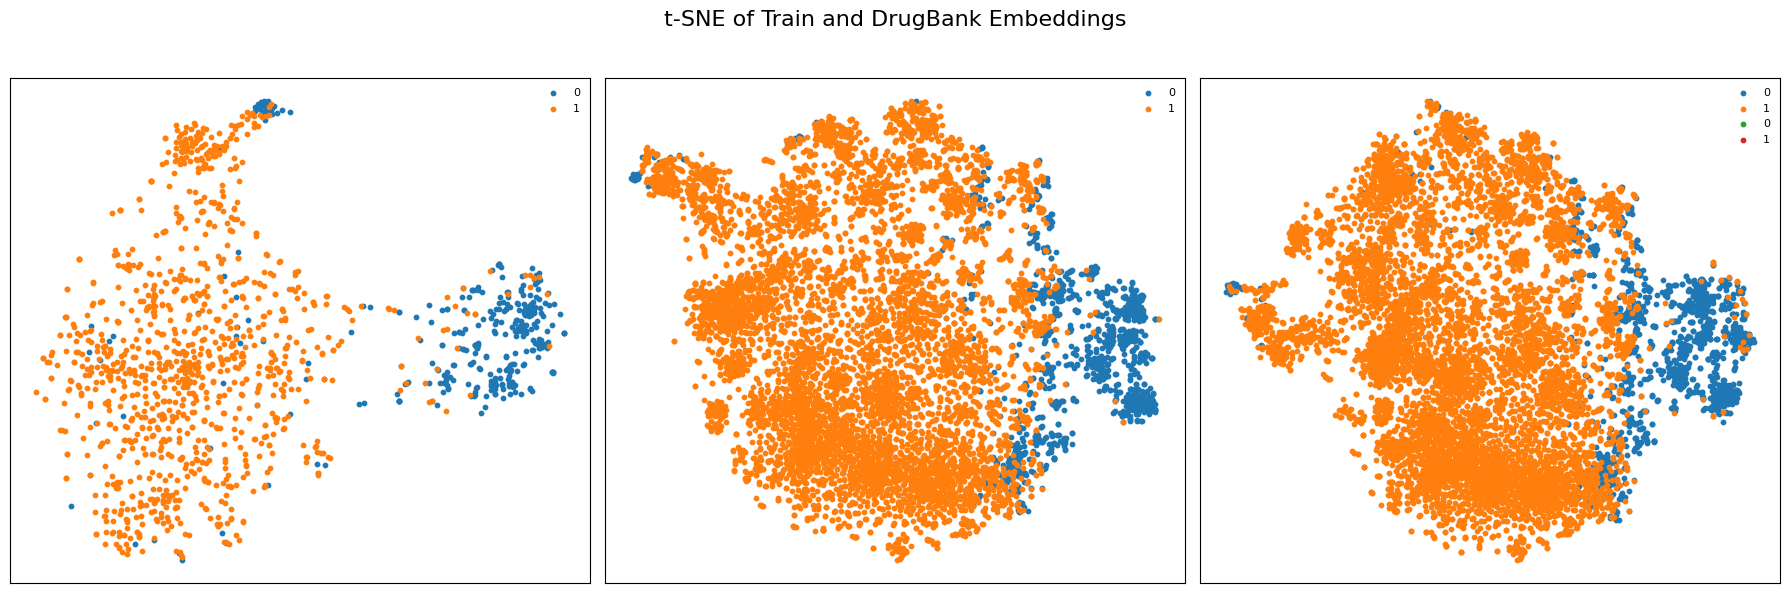

In [60]:
def tsne_plot_embeddings(ax, embeddings, labels, class_names, title=None):
    latent_space_tsne = TSNE(2, verbose=False, n_iter=2000, metric="cosine", perplexity=50, learning_rate=500)
    xa_tsne = latent_space_tsne.fit_transform(embeddings)
    colors = plt.rcParams["axes.prop_cycle"]()

    for class_idx in range(len(class_names)):
        c = next(colors)["color"]
        ax.scatter(xa_tsne[:,0][labels==class_idx], xa_tsne[:,1][labels==class_idx], color=c, label=class_names[class_idx], s=10)

    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.legend(loc='best', fontsize=8, frameon=False)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

train_dataset = load_dataset('data/BBB_train.csv')
train_embeddings = train_embeddings.reshape(train_embeddings.shape[0], -1)
train_labels = np.array(train_dataset['label'], dtype=int)
train_class_names = np.unique(train_labels)

tsne_plot_embeddings(ax[0], train_embeddings, train_labels, train_class_names, title="Train Embeddings")

drugbank_embeddings = drugbank_embeddings.reshape(drugbank_embeddings.shape[0], -1)
drugbank_labels = np.array(drugbank_smiles['predictions'], dtype=int)
drugbank_class_names = np.unique(drugbank_labels)

tsne_plot_embeddings(ax[1], drugbank_embeddings, drugbank_labels, drugbank_class_names, title="DrugBank Embeddings")

combined_embeddings = np.vstack((train_embeddings, drugbank_embeddings))
combined_labels = np.concatenate((train_labels, drugbank_labels))
combined_class_names = list(train_class_names) + list(drugbank_class_names)

tsne_plot_embeddings(ax[2], combined_embeddings, combined_labels, combined_class_names, title="Combined Embeddings")

fig.suptitle('t-SNE of Train and DrugBank Embeddings', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("plots/tsne_combined_embeddings.png")
plt.show()

In [64]:
import torch
import torch.nn as nn

@torch.no_grad()
def OOD_classifier_knn(train_features, train_labels, test_features, test_labels, k=1):
    """
    Args:
        train_features: Tensor of shape NxD (training features)
        train_labels: List or Tensor of length N (training labels)
        test_features: Tensor of shape KxD (test features)
        test_labels: List or Tensor of length K (test labels)
        k: Number of closest train features to consider.

    Returns:
        ood_scores: List of length K, where each element indicates
                    the OOD score for the corresponding test feature.
                    0.0 means in-distribution (ID), 1.0 means out-of-distribution (OOD).
    """
    num_chunks = 16
    k = len(train_features) if k < 0 else k
    num_test_images = test_features.shape[0]
    imgs_per_chunk = num_test_images // num_chunks
    ood_scores = []

    train_features = nn.functional.normalize(train_features, dim=-1, p=2)
    test_features = nn.functional.normalize(test_features, dim=-1, p=2)

    for idx in range(0, num_test_images, imgs_per_chunk):
        idx_next_chunk = min((idx + imgs_per_chunk), num_test_images)
        features = test_features[idx: idx_next_chunk, :]

        similarity = features @ train_features.T
        top_sim, top_indices = similarity.topk(k, largest=True, sorted=True, dim=-1)

        for i in range(idx, idx_next_chunk):
            test_label = test_labels[i]
            nearest_labels = [train_labels[idx.item()] for idx in top_indices[i - idx]]
            majority_label = max(set(nearest_labels), key=nearest_labels.count)

            if test_label == majority_label:
                ood_scores.append(0.0)  # ID
            else:
                ood_scores.append(1.0)  # OOD

    return ood_scores


train_embeddings = np.load('data/train_embeddings.npy')
drugbank_embeddings = np.load('data/drugbank_embeddings.npy')

train_features = torch.tensor(train_embeddings, dtype=torch.float32)
drugbank_features = torch.tensor(drugbank_embeddings, dtype=torch.float32)

ood_score = OOD_classifier_knn(train_features, train_labels, drugbank_features, drugbank_labels, k=5)

In [67]:
drugbank_smiles['ood_score'] = ood_score

In [72]:
len(drugbank_smiles[drugbank_smiles['ood_score'] == 1])

266

In [74]:
drugbank_smiles.head()

,text,predictions,logits_0,logits_1,logits_0_norm,logits_1_norm,ood_score
0,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,0,2.621075,-2.419240,0.871084,0.135837,0.0
1,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,0,2.503959,-2.361791,0.855103,0.144039,0.0
2,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,0,2.522887,-2.346393,0.857685,0.146237,0.0
3,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,0,2.006991,-1.884559,0.787290,0.212169,0.0
4,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...,0,2.264112,-2.087749,0.822375,0.183161,0.0


In [118]:
generated_train_dataset = drugbank_smiles[(drugbank_smiles['ood_score'] == 0) & ((drugbank_smiles['logits_0_norm'].between(0.5, 0.8)) | (drugbank_smiles['logits_1_norm'].between(0.5, 0.8)))]


In [119]:
generated_train_dataset.head()

,text,predictions,logits_0,logits_1,logits_0_norm,logits_1_norm,ood_score
3,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,0,2.006991,-1.884559,0.787290,0.212169,0.0
6,CCCCCCCCCC(=O)N[C@@H](CC1=CNC2=C1C=CC=C2)C(=O)...,0,1.920076,-1.773439,0.775430,0.228032,0.0
7,NCCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1CSSC[...,0,1.487443,-1.315737,0.716397,0.293374,0.0
10,CC1=NC=C(COP(O)(O)=O)C(C=O)=C1O,1,-1.289504,1.266437,0.337475,0.662007,0.0
11,C[C@H](CNC(=O)CC[C@]1(C)[C@@H](CC(N)=O)[C@H]2N...,0,1.991714,-1.903637,0.785206,0.209445,0.0


In [120]:
generated_train_dataset = generated_train_dataset.rename(columns={'predictions': 'label'}).copy()
generated_train_dataset = generated_train_dataset[['text', 'label']]

In [121]:
generated_train_dataset.to_csv('data/generated_train_dataset.csv', index=False)